<a href="https://colab.research.google.com/github/Team-32-Skilvull/Klasifikasi-Kaleng-Cacat/blob/master/Stages_of_model_training_experiments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Found 1264 images belonging to 2 classes.
Found 360 images belonging to 2 classes.
Epoch 1/47
39/39 [==============================] - ETA: 0s - loss: 4.3311 - accuracy: 0.5966

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


39/39 [==============================] - 385s 9s/step - loss: 4.3311 - accuracy: 0.5966 - val_loss: 4.0379 - val_accuracy: 0.4716 - lr: 0.0010
Epoch 2/47
39/39 [==============================] - 53s 1s/step - loss: 3.1043 - accuracy: 0.6209 - val_loss: 2.6728 - val_accuracy: 0.5028 - lr: 0.0010
Epoch 3/47
39/39 [==============================] - 44s 1s/step - loss: 2.1885 - accuracy: 0.6729 - val_loss: 2.2668 - val_accuracy: 0.4972 - lr: 0.0010
Epoch 4/47
39/39 [==============================] - 42s 1s/step - loss: 1.7219 - accuracy: 0.6713 - val_loss: 1.8940 - val_accuracy: 0.5028 - lr: 0.0010
Epoch 5/47
39/39 [==============================] - 51s 1s/step - loss: 1.5339 - accuracy: 0.6469 - val_loss: 1.5610 - val_accuracy: 0.5256 - lr: 0.0010
Epoch 6/47
39/39 [==============================] - 44s 1s/step - loss: 1.3373 - accuracy: 0.6583 - val_loss: 1.4856 - val_accuracy: 0.4858 - lr: 0.0010
Epoch 7/47
39/39 [==============================] - 44s 1s/step - loss: 1.2163 - accuracy: 0

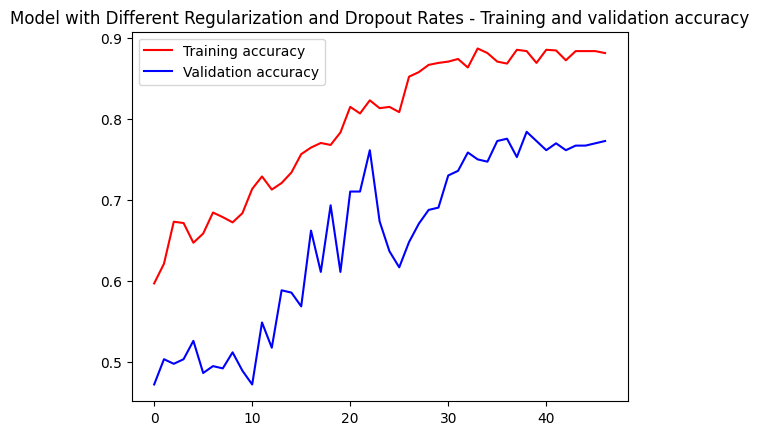

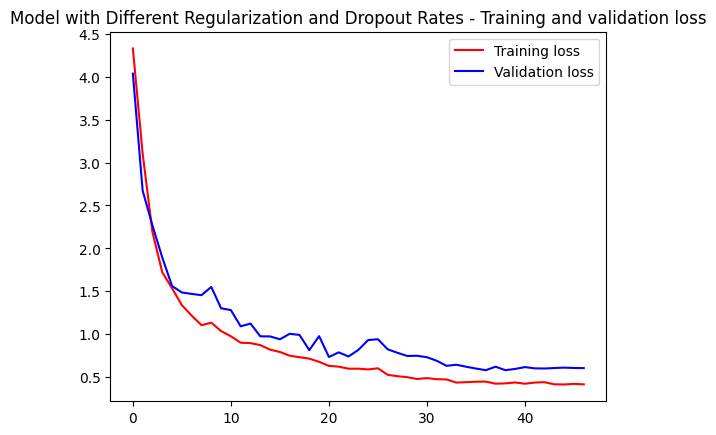

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, LeakyReLU, BatchNormalization
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

# Path ke dataset
train_dir = '/content/drive/MyDrive/SKILVUL/Capstone/newdataset_kaleng/dataset_kaleng/training'
validation_dir = '/content/drive/MyDrive/SKILVUL/Capstone/newdataset_kaleng/dataset_kaleng/validasi'

# Data augmentation dan normalisasi
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,  # Mengurangi rotasi
    width_shift_range=0.2,  # Mengurangi pergeseran
    height_shift_range=0.2,
    shear_range=0.2,  # Mengurangi shear
    zoom_range=0.2,  # Mengurangi zoom
    horizontal_flip=True,
    fill_mode='nearest'
)

validation_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(300, 300),
    batch_size=32,
    class_mode='binary'
)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(300, 300),
    batch_size=32,
    class_mode='binary'
)

# Membangun model CNN dengan perbaikan dan variasi regularisasi
model = Sequential([
    Conv2D(64, (3, 3), input_shape=(300, 300, 3)),  # Menghapus regularisasi pada layer pertama
    BatchNormalization(),
    LeakyReLU(alpha=0.1),
    MaxPooling2D(2, 2),

    Conv2D(128, (3, 3), kernel_regularizer=l2(0.001)),  # Tetap menggunakan L2 regularisasi pada layer berikutnya
    BatchNormalization(),
    LeakyReLU(alpha=0.1),
    MaxPooling2D(2, 2),

    Conv2D(256, (3, 3), kernel_regularizer=l2(0.001)),  # Mengurangi regularisasi menjadi L2
    BatchNormalization(),
    LeakyReLU(alpha=0.1),
    MaxPooling2D(2, 2),

    Conv2D(256, (3, 3), kernel_regularizer=l2(0.001)),  # Mengurangi regularisasi menjadi L2
    BatchNormalization(),
    LeakyReLU(alpha=0.1),
    MaxPooling2D(2, 2),

    Flatten(),
    Dense(1024, kernel_regularizer=l2(0.001)),  # Mengurangi regularisasi pada Dense layer
    BatchNormalization(),
    LeakyReLU(alpha=0.1),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

# Kompilasi model
model.compile(
    loss='binary_crossentropy',
    optimizer=Adam(learning_rate=1e-3),  # Meningkatkan learning rate awal
    metrics=['accuracy']
)

# Definisikan callbacks
model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)

# Penggunaan LearningRateScheduler
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)

# Melatih model dengan modifikasi
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=47,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    callbacks=[model_checkpoint, reduce_lr, lr_scheduler]
)

# Mengevaluasi dan membandingkan hasil
def plot_history(history, title):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.plot(epochs, acc, 'r', label='Training accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
    plt.title(f'{title} - Training and validation accuracy')
    plt.legend()
    plt.figure()

    plt.plot(epochs, loss, 'r', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title(f'{title} - Training and validation loss')
    plt.legend()
    plt.show()

plot_history(history, 'Model with Different Regularization and Dropout Rates')

# Menyimpan model
model.save('model1.h5')

Found 1264 images belonging to 2 classes.
Found 360 images belonging to 2 classes.
Epoch 1/47
39/39 [==============================] - 55s 1s/step - loss: 19.9200 - accuracy: 0.5690 - val_loss: 19.2806 - val_accuracy: 0.5057 - lr: 1.0000e-04
Epoch 2/47
39/39 [==============================] - 45s 1s/step - loss: 18.7648 - accuracy: 0.5998 - val_loss: 18.4644 - val_accuracy: 0.4943 - lr: 1.0000e-04
Epoch 3/47
39/39 [==============================] - 43s 1s/step - loss: 17.8331 - accuracy: 0.6705 - val_loss: 17.4637 - val_accuracy: 0.4972 - lr: 1.0000e-04
Epoch 4/47
39/39 [==============================] - 45s 1s/step - loss: 16.8832 - accuracy: 0.6761 - val_loss: 16.4993 - val_accuracy: 0.5000 - lr: 1.0000e-04
Epoch 5/47
39/39 [==============================] - 46s 1s/step - loss: 15.8949 - accuracy: 0.6940 - val_loss: 15.5319 - val_accuracy: 0.5256 - lr: 1.0000e-04
Epoch 6/47
39/39 [==============================] - 46s 1s/step - loss: 14.9574 - accuracy: 0.6810 - val_loss: 14.8954 - v

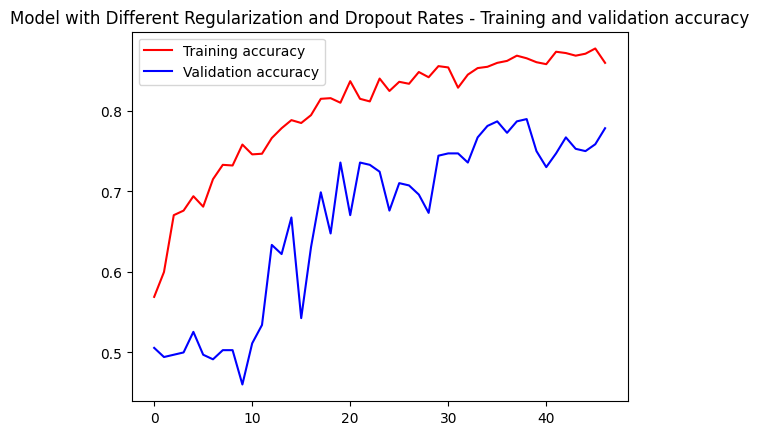

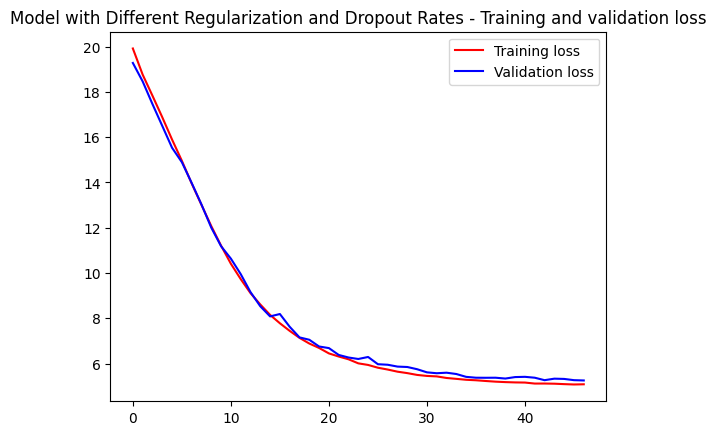

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, LeakyReLU, BatchNormalization
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from tensorflow.keras.regularizers import l2, l1
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

# Path ke dataset
train_dir = '/content/drive/MyDrive/SKILVUL/Capstone/newdataset_kaleng/dataset_kaleng/training'
validation_dir = '/content/drive/MyDrive/SKILVUL/Capstone/newdataset_kaleng/dataset_kaleng/validasi'

# Data augmentation dan normalisasi
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    fill_mode='nearest'
)

validation_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(300, 300),
    batch_size=32,
    class_mode='binary'
)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(300, 300),
    batch_size=32,
    class_mode='binary'
)

# Membangun model CNN dengan perbaikan dan variasi regularisasi
model = Sequential([
    Conv2D(64, (3, 3), input_shape=(300, 300, 3)),  # hapus L2 regularization pada Conv2D
    BatchNormalization(),
    LeakyReLU(alpha=0.1),
    MaxPooling2D(2, 2),

    Conv2D(128, (3, 3), kernel_regularizer=l2(0.001)),  # L2 regularization pada Conv2D
    BatchNormalization(),
    LeakyReLU(alpha=0.1),
    MaxPooling2D(2, 2),

    Conv2D(256, (3, 3), kernel_regularizer=l1(0.001)),  # L1 regularization pada Conv2D
    BatchNormalization(),
    LeakyReLU(alpha=0.1),
    MaxPooling2D(2, 2),

    Conv2D(256, (3, 3), kernel_regularizer=l1(0.001)),  # L1 regularization pada Conv2D
    BatchNormalization(),
    LeakyReLU(alpha=0.1),
    MaxPooling2D(2, 2),

    Flatten(),
    Dense(1024, kernel_regularizer=l2(0.001)),  # L2 regularization pada Dense
    BatchNormalization(),
    LeakyReLU(alpha=0.1),
    Dropout(0.3),  # Mengubah dropout rate
    Dense(1, activation='sigmoid')
])

# Kompilasi model
model.compile(
    loss='binary_crossentropy',
    optimizer=Adam(learning_rate=1e-4),
    metrics=['accuracy']
)

# Definisikan callbacks
model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)

# Penggunaan LearningRateScheduler
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)

# Melatih model dengan modifikasi
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=47,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    callbacks=[model_checkpoint, reduce_lr, lr_scheduler]
)

# Mengevaluasi dan membandingkan hasil
def plot_history(history, title):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.plot(epochs, acc, 'r', label='Training accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
    plt.title(f'{title} - Training and validation accuracy')
    plt.legend()
    plt.figure()

    plt.plot(epochs, loss, 'r', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title(f'{title} - Training and validation loss')
    plt.legend()
    plt.show()

plot_history(history, 'Model with Different Regularization and Dropout Rates')

# Menyimpan model
model.save('model_regularized.h5')

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, LeakyReLU, BatchNormalization
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from tensorflow.keras.regularizers import l2, l1
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

# Path ke dataset
train_dir = '/content/drive/MyDrive/SKILVUL/Capstone/newdataset_kaleng/dataset_kaleng/training'
validation_dir = '/content/drive/MyDrive/SKILVUL/Capstone/newdataset_kaleng/dataset_kaleng/validasi'

# Data augmentation dan normalisasi
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    fill_mode='nearest'
)

validation_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(300, 300),
    batch_size=32,
    class_mode='binary'
)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(300, 300),
    batch_size=32,
    class_mode='binary'
)

# Membangun model CNN dengan perbaikan dan variasi regularisasi
model = Sequential([
    Conv2D(64, (3, 3), input_shape=(300, 300, 3), kernel_regularizer=l2(0.001)),  # L2 regularization pada Conv2D
    BatchNormalization(),
    LeakyReLU(alpha=0.1),
    MaxPooling2D(2, 2),

    Conv2D(128, (3, 3), kernel_regularizer=l2(0.001)),  # L2 regularization pada Conv2D
    BatchNormalization(),
    LeakyReLU(alpha=0.1),
    MaxPooling2D(2, 2),

    Conv2D(256, (3, 3), kernel_regularizer=l1(0.001)),  # L1 regularization pada Conv2D
    BatchNormalization(),
    LeakyReLU(alpha=0.1),
    MaxPooling2D(2, 2),

    Conv2D(256, (3, 3), kernel_regularizer=l1(0.001)),  # L1 regularization pada Conv2D
    BatchNormalization(),
    LeakyReLU(alpha=0.1),
    MaxPooling2D(2, 2),

    Flatten(),
    Dense(1024, kernel_regularizer=l2(0.001)),  # L2 regularization pada Dense
    BatchNormalization(),
    LeakyReLU(alpha=0.1),
    Dropout(0.3),  # Mengubah dropout rate
    Dense(1, activation='sigmoid')
])

# Kompilasi model
model.compile(
    loss='binary_crossentropy',
    optimizer=Adam(learning_rate=1e-4),
    metrics=['accuracy']
)

# Definisikan callbacks
model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)

# Penggunaan LearningRateScheduler
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)

# Melatih model dengan modifikasi
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=47,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    callbacks=[model_checkpoint, reduce_lr, lr_scheduler]
)

# Mengevaluasi dan membandingkan hasil
def plot_history(history, title):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.plot(epochs, acc, 'r', label='Training accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
    plt.title(f'{title} - Training and validation accuracy')
    plt.legend()
    plt.figure()

    plt.plot(epochs, loss, 'r', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title(f'{title} - Training and validation loss')
    plt.legend()
    plt.show()

plot_history(history, 'Model with Different Regularization and Dropout Rates')

# Menyimpan model
model.save('model2.h5')

Found 1264 images belonging to 2 classes.
Found 360 images belonging to 2 classes.
Epoch 1/47
39/39 [==============================] - 58s 1s/step - loss: 19.8378 - accuracy: 0.6023 - val_loss: 19.0356 - val_accuracy: 0.5000 - lr: 1.0000e-04
Epoch 2/47
39/39 [==============================] - 44s 1s/step - loss: 18.5877 - accuracy: 0.6469 - val_loss: 18.1534 - val_accuracy: 0.4773 - lr: 1.0000e-04
Epoch 3/47
39/39 [==============================] - 45s 1s/step - loss: 17.6323 - accuracy: 0.6631 - val_loss: 17.1830 - val_accuracy: 0.5000 - lr: 1.0000e-04
Epoch 4/47
39/39 [==============================] - 49s 1s/step - loss: 16.6248 - accuracy: 0.6753 - val_loss: 16.3182 - val_accuracy: 0.5000 - lr: 1.0000e-04
Epoch 5/47
39/39 [==============================] - 53s 1s/step - loss: 15.5824 - accuracy: 0.6810 - val_loss: 15.3741 - val_accuracy: 0.5028 - lr: 1.0000e-04
Epoch 6/47
39/39 [==============================] - 55s 1s/step - loss: 14.5561 - accuracy: 0.7054 - val_loss: 14.1850 - v

Found 1264 images belonging to 2 classes.
Found 360 images belonging to 2 classes.
Epoch 1/50
39/39 [==============================] - ETA: 0s - loss: 1.1792 - accuracy: 0.5519

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


39/39 [==============================] - 429s 11s/step - loss: 1.1792 - accuracy: 0.5519 - val_loss: 0.9726 - val_accuracy: 0.4943 - lr: 3.0000e-04
Epoch 2/50
39/39 [==============================] - 60s 2s/step - loss: 0.7187 - accuracy: 0.6120 - val_loss: 0.9352 - val_accuracy: 0.4972 - lr: 3.0000e-04
Epoch 3/50
39/39 [==============================] - 61s 2s/step - loss: 0.6770 - accuracy: 0.6518 - val_loss: 0.7323 - val_accuracy: 0.5028 - lr: 3.0000e-04
Epoch 4/50
39/39 [==============================] - 47s 1s/step - loss: 0.6411 - accuracy: 0.6607 - val_loss: 1.1495 - val_accuracy: 0.4972 - lr: 3.0000e-04
Epoch 5/50
39/39 [==============================] - 61s 2s/step - loss: 0.6684 - accuracy: 0.6502 - val_loss: 1.1754 - val_accuracy: 0.5057 - lr: 3.0000e-04
Epoch 6/50
39/39 [==============================] - 44s 1s/step - loss: 0.6273 - accuracy: 0.6705 - val_loss: 1.2913 - val_accuracy: 0.5000 - lr: 3.0000e-04
Epoch 7/50
39/39 [==============================] - 44s 1s/step - l

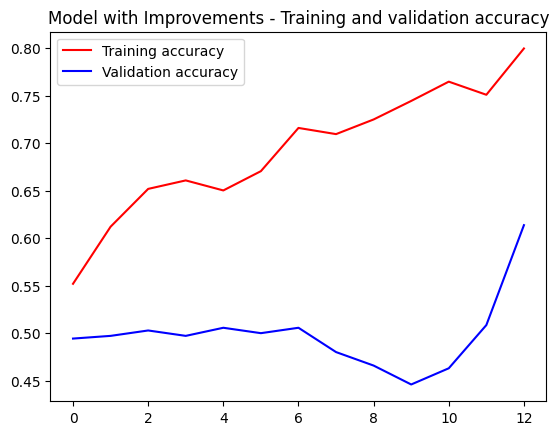

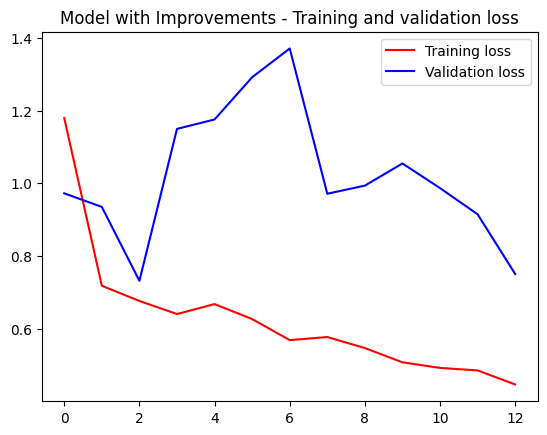

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, LeakyReLU, BatchNormalization
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# Path ke dataset
train_dir = '/content/drive/MyDrive/SKILVUL/Capstone/newdataset_kaleng/dataset_kaleng/training'
validation_dir = '/content/drive/MyDrive/SKILVUL/Capstone/newdataset_kaleng/dataset_kaleng/validasi'

# Data augmentation dan normalisasi
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    brightness_range=[0.8, 1.2]  # Menambah variasi kecerahan
)

validation_datagen = ImageDataGenerator(rescale=1./255)

# Generator data
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(300, 300),
    batch_size=32,
    class_mode='binary'
)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(300, 300),
    batch_size=32,
    class_mode='binary'
)

# Membangun model CNN
model = Sequential([
    Conv2D(64, (3, 3), padding='same', input_shape=(300, 300, 3)),
    BatchNormalization(),
    LeakyReLU(alpha=0.1),
    MaxPooling2D(2, 2),

    Conv2D(128, (3, 3), padding='same'),
    BatchNormalization(),
    LeakyReLU(alpha=0.1),
    MaxPooling2D(2, 2),

    Conv2D(256, (3, 3), padding='same'),
    BatchNormalization(),
    LeakyReLU(alpha=0.1),
    MaxPooling2D(2, 2),

    Conv2D(512, (3, 3), padding='same'),
    BatchNormalization(),
    LeakyReLU(alpha=0.1),
    MaxPooling2D(2, 2),

    Flatten(),
    Dense(1024),
    BatchNormalization(),
    LeakyReLU(alpha=0.1),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Kompilasi model
model.compile(
    loss='binary_crossentropy',
    optimizer=Adam(learning_rate=3e-4),  # Meningkatkan learning rate sedikit
    metrics=['accuracy']
)

# Definisikan callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)

# Melatih model dengan modifikasi
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=50,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    callbacks=[early_stopping, model_checkpoint, reduce_lr]
)

# Plot history
def plot_history(history, title):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.plot(epochs, acc, 'r', label='Training accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
    plt.title(f'{title} - Training and validation accuracy')
    plt.legend()
    plt.figure()

    plt.plot(epochs, loss, 'r', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title(f'{title} - Training and validation loss')
    plt.legend()
    plt.show()

plot_history(history, 'Model with Improvements')

# Menyimpan model
model.save('model_improved1.h5')

Found 1264 images belonging to 2 classes.
Found 360 images belonging to 2 classes.
Epoch 1/50
39/39 [==============================] - 54s 1s/step - loss: 2.2635 - accuracy: 0.5804 - val_loss: 2.0132 - val_accuracy: 0.5000 - lr: 1.0000e-04
Epoch 2/50
39/39 [==============================] - 42s 1s/step - loss: 2.0239 - accuracy: 0.6234 - val_loss: 2.0419 - val_accuracy: 0.5000 - lr: 1.0000e-04
Epoch 3/50
39/39 [==============================] - 42s 1s/step - loss: 1.9590 - accuracy: 0.6291 - val_loss: 1.9915 - val_accuracy: 0.4972 - lr: 1.0000e-04
Epoch 4/50
39/39 [==============================] - 50s 1s/step - loss: 1.9109 - accuracy: 0.6388 - val_loss: 1.9539 - val_accuracy: 0.5057 - lr: 1.0000e-04
Epoch 5/50
39/39 [==============================] - 42s 1s/step - loss: 1.8290 - accuracy: 0.6558 - val_loss: 2.0102 - val_accuracy: 0.4915 - lr: 1.0000e-04
Epoch 6/50
39/39 [==============================] - 42s 1s/step - loss: 1.7761 - accuracy: 0.6672 - val_loss: 1.8685 - val_accuracy:

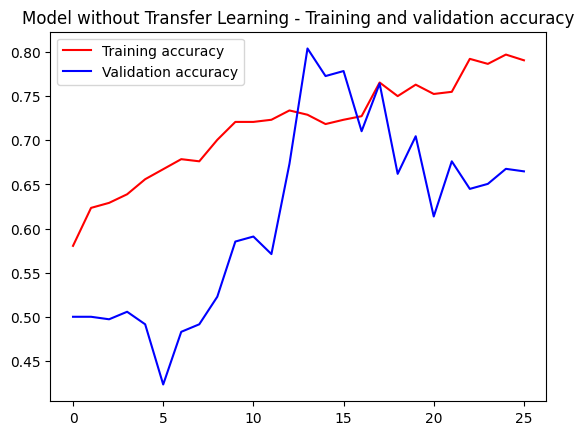

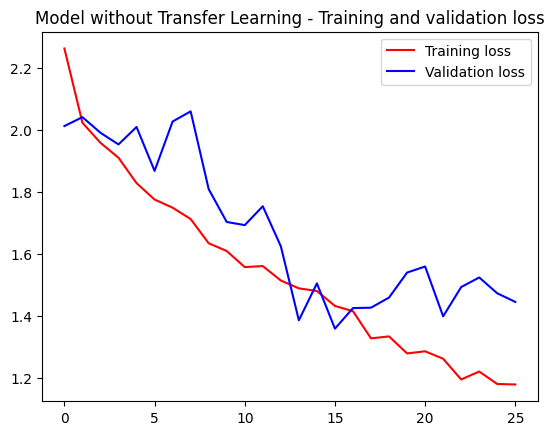

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, LeakyReLU, BatchNormalization
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# Path ke dataset
train_dir = '/content/drive/MyDrive/SKILVUL/Capstone/newdataset_kaleng/dataset_kaleng/training'
validation_dir = '/content/drive/MyDrive/SKILVUL/Capstone/newdataset_kaleng/dataset_kaleng/validasi'

# Data augmentation dan normalisasi
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    fill_mode='nearest',
    brightness_range=[0.8, 1.2]
)

validation_datagen = ImageDataGenerator(rescale=1./255)

# Generator data
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(300, 300),
    batch_size=32,
    class_mode='binary'
)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(300, 300),
    batch_size=32,
    class_mode='binary'
)

# Membangun model CNN yang lebih sederhana
model = Sequential([
    Conv2D(32, (3, 3), padding='same', kernel_regularizer=l2(0.001), input_shape=(300, 300, 3)),
    BatchNormalization(),
    LeakyReLU(alpha=0.1),
    MaxPooling2D(2, 2),

    Conv2D(64, (3, 3), padding='same', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    LeakyReLU(alpha=0.1),
    MaxPooling2D(2, 2),

    Conv2D(128, (3, 3), padding='same', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    LeakyReLU(alpha=0.1),
    MaxPooling2D(2, 2),

    Conv2D(256, (3, 3), padding='same', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    LeakyReLU(alpha=0.1),
    MaxPooling2D(2, 2),

    Flatten(),
    Dense(512, kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    LeakyReLU(alpha=0.1),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Kompilasi model
model.compile(
    loss='binary_crossentropy',
    optimizer=Adam(learning_rate=1e-4),
    metrics=['accuracy']
)

# Definisikan callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)

# Melatih model dengan modifikasi
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=50,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    callbacks=[early_stopping, model_checkpoint, reduce_lr]
)

# Plot history
def plot_history(history, title):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.plot(epochs, acc, 'r', label='Training accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
    plt.title(f'{title} - Training and validation accuracy')
    plt.legend()
    plt.figure()

    plt.plot(epochs, loss, 'r', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title(f'{title} - Training and validation loss')
    plt.legend()
    plt.show()

plot_history(history, 'Model without Transfer Learning')

# Menyimpan model
model.save('model2.h5')

Found 1264 images belonging to 2 classes.
Found 360 images belonging to 2 classes.
Epoch 1/50
39/39 [==============================] - 23s 459ms/step - loss: 2.2507 - accuracy: 0.5763 - val_loss: 2.0356 - val_accuracy: 0.5085 - lr: 1.0000e-04
Epoch 2/50
39/39 [==============================] - 16s 407ms/step - loss: 2.0654 - accuracy: 0.6047 - val_loss: 2.1175 - val_accuracy: 0.5028 - lr: 1.0000e-04
Epoch 3/50
39/39 [==============================] - 16s 404ms/step - loss: 1.9582 - accuracy: 0.6315 - val_loss: 2.1911 - val_accuracy: 0.5000 - lr: 1.0000e-04
Epoch 4/50
39/39 [==============================] - 16s 414ms/step - loss: 1.9517 - accuracy: 0.6282 - val_loss: 2.1538 - val_accuracy: 0.5057 - lr: 1.0000e-04
Epoch 5/50
39/39 [==============================] - 17s 436ms/step - loss: 1.8681 - accuracy: 0.6745 - val_loss: 2.2055 - val_accuracy: 0.5000 - lr: 1.0000e-04
Epoch 6/50
39/39 [==============================] - 16s 418ms/step - loss: 1.8623 - accuracy: 0.6794 - val_loss: 2.26

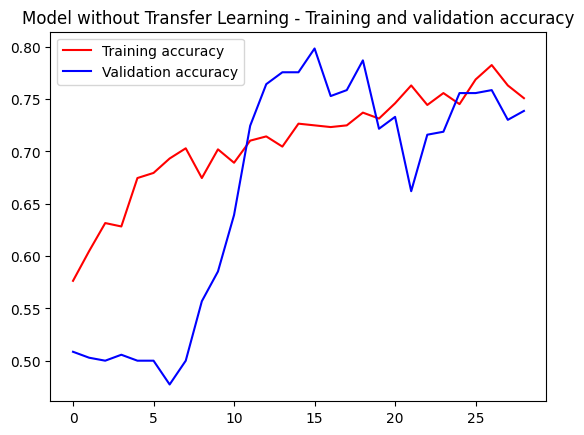

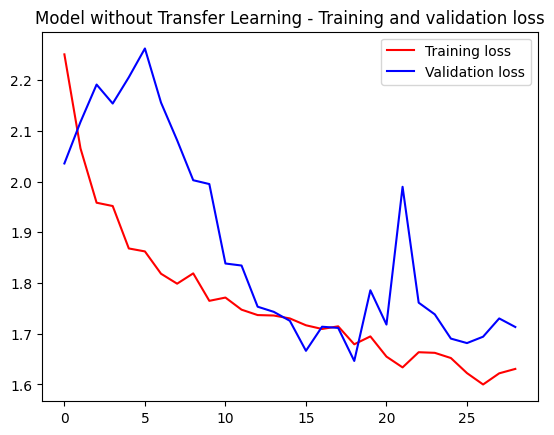

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# Path ke dataset
train_dir = '/content/drive/MyDrive/SKILVUL/Capstone/newdataset_kaleng/dataset_kaleng/training'
validation_dir = '/content/drive/MyDrive/SKILVUL/Capstone/newdataset_kaleng/dataset_kaleng/validasi'

# Data Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    fill_mode='nearest',
    brightness_range=[0.8, 1.2]
)

validation_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary'
)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary'
)

# Membangun model CNN
model = Sequential([
    Conv2D(32, (3, 3), padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.001), input_shape=(150, 150, 3)),
    BatchNormalization(),
    LeakyReLU(alpha=0.1),
    MaxPooling2D(2, 2),

    Conv2D(64, (3, 3), padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    BatchNormalization(),
    LeakyReLU(alpha=0.1),
    MaxPooling2D(2, 2),

    Conv2D(128, (3, 3), padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    BatchNormalization(),
    LeakyReLU(alpha=0.1),
    MaxPooling2D(2, 2),

    Conv2D(256, (3, 3), padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    BatchNormalization(),
    LeakyReLU(alpha=0.1),
    MaxPooling2D(2, 2),

    Flatten(),
    Dense(512, kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    BatchNormalization(),
    LeakyReLU(alpha=0.1),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Kompilasi model
model.compile(
    loss='binary_crossentropy',
    optimizer=Adam(learning_rate=1e-4),
    metrics=['accuracy']
)

# Definisikan callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)

# Melatih model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=50,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    callbacks=[early_stopping, model_checkpoint, reduce_lr]
)

# Plot history
import matplotlib.pyplot as plt

def plot_history(history, title):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.plot(epochs, acc, 'r', label='Training accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
    plt.title(f'{title} - Training and validation accuracy')
    plt.legend()
    plt.figure()

    plt.plot(epochs, loss, 'r', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title(f'{title} - Training and validation loss')
    plt.legend()
    plt.show()

plot_history(history, 'Model without Transfer Learning')

# Menyimpan model
model.save('model3.h5')

Found 1264 images belonging to 2 classes.
Found 360 images belonging to 2 classes.
Epoch 1/50
39/39 [==============================] - 22s 429ms/step - loss: 1.5310 - accuracy: 0.5373 - val_loss: 1.3519 - val_accuracy: 0.5057 - lr: 1.0000e-04
Epoch 2/50
39/39 [==============================] - 16s 423ms/step - loss: 1.4011 - accuracy: 0.5917 - val_loss: 1.3557 - val_accuracy: 0.5000 - lr: 1.0000e-04
Epoch 3/50
39/39 [==============================] - 16s 418ms/step - loss: 1.3683 - accuracy: 0.6096 - val_loss: 1.4864 - val_accuracy: 0.5000 - lr: 1.0000e-04
Epoch 4/50
39/39 [==============================] - 17s 426ms/step - loss: 1.3491 - accuracy: 0.6088 - val_loss: 1.5467 - val_accuracy: 0.5057 - lr: 1.0000e-04
Epoch 5/50
39/39 [==============================] - 16s 404ms/step - loss: 1.3301 - accuracy: 0.6185 - val_loss: 1.5240 - val_accuracy: 0.5000 - lr: 2.0000e-05
Epoch 6/50
39/39 [==============================] - 16s 425ms/step - loss: 1.3227 - accuracy: 0.6178 - val_loss: 1.50

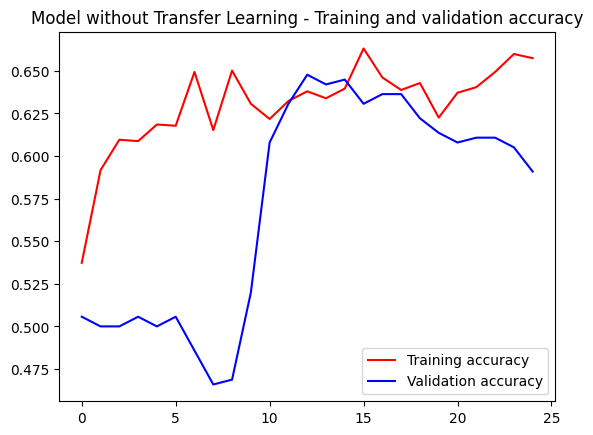

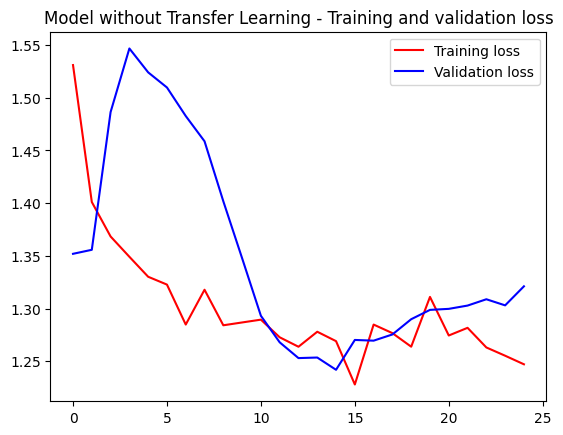

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# Path ke dataset
train_dir = '/content/drive/MyDrive/SKILVUL/Capstone/newdataset_kaleng/dataset_kaleng/training'
validation_dir = '/content/drive/MyDrive/SKILVUL/Capstone/newdataset_kaleng/dataset_kaleng/validasi'

# Data Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    fill_mode='nearest',
    brightness_range=[0.8, 1.2]
)

validation_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary'
)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary'
)

# Membangun model CNN
model = Sequential([
    Conv2D(16, (3, 3), padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.001), input_shape=(150, 150, 3)),
    BatchNormalization(),
    LeakyReLU(alpha=0.1),
    MaxPooling2D(2, 2),

    Conv2D(32, (3, 3), padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    BatchNormalization(),
    LeakyReLU(alpha=0.1),
    MaxPooling2D(2, 2),

    Conv2D(64, (3, 3), padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    BatchNormalization(),
    LeakyReLU(alpha=0.1),
    MaxPooling2D(2, 2),

    Conv2D(128, (3, 3), padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    BatchNormalization(),
    LeakyReLU(alpha=0.1),
    MaxPooling2D(2, 2),

    Flatten(),
    Dense(256, kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    BatchNormalization(),
    LeakyReLU(alpha=0.1),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Kompilasi model
model.compile(
    loss='binary_crossentropy',
    optimizer=Adam(learning_rate=1e-4),
    metrics=['accuracy']
)

# Definisikan callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

# Melatih model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=50,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    callbacks=[early_stopping, model_checkpoint, reduce_lr]
)

# Plot history
import matplotlib.pyplot as plt

def plot_history(history, title):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.plot(epochs, acc, 'r', label='Training accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
    plt.title(f'{title} - Training and validation accuracy')
    plt.legend()
    plt.figure()

    plt.plot(epochs, loss, 'r', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title(f'{title} - Training and validation loss')
    plt.legend()
    plt.show()

plot_history(history, 'Model without Transfer Learning')

# Menyimpan model
model.save('model4.h5')

Found 1264 images belonging to 2 classes.
Found 360 images belonging to 2 classes.
Epoch 1/50
39/39 [==============================] - 57s 1s/step - loss: 0.5519 - accuracy: 0.7670 - val_loss: 0.6857 - val_accuracy: 0.7443 - lr: 1.0000e-04
Epoch 2/50
39/39 [==============================] - 42s 1s/step - loss: 0.4036 - accuracy: 0.8612 - val_loss: 0.6632 - val_accuracy: 0.7273 - lr: 1.0000e-04
Epoch 3/50
39/39 [==============================] - 42s 1s/step - loss: 0.3668 - accuracy: 0.8782 - val_loss: 0.6564 - val_accuracy: 0.6761 - lr: 1.0000e-04
Epoch 4/50
39/39 [==============================] - 43s 1s/step - loss: 0.3252 - accuracy: 0.8945 - val_loss: 0.6339 - val_accuracy: 0.6989 - lr: 1.0000e-04
Epoch 5/50
39/39 [==============================] - 45s 1s/step - loss: 0.3213 - accuracy: 0.9002 - val_loss: 0.5859 - val_accuracy: 0.7642 - lr: 1.0000e-04
Epoch 6/50
39/39 [==============================] - 43s 1s/step - loss: 0.2886 - accuracy: 0.9123 - val_loss: 0.5533 - val_accuracy:

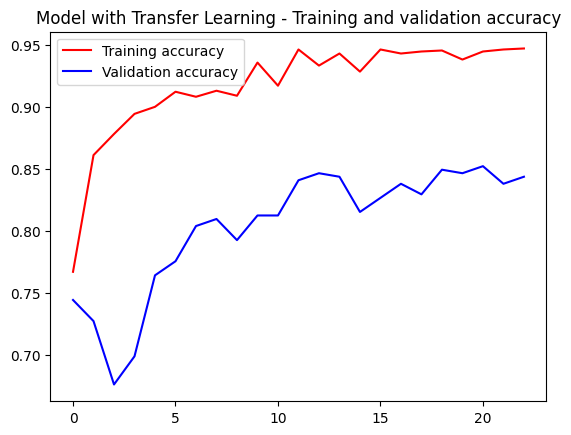

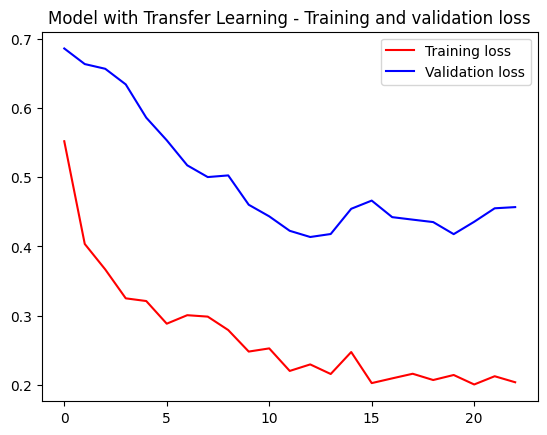

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, LeakyReLU, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# Path ke dataset
train_dir = '/content/drive/MyDrive/SKILVUL/Capstone/newdataset_kaleng/dataset_kaleng/training'
validation_dir = '/content/drive/MyDrive/SKILVUL/Capstone/newdataset_kaleng/dataset_kaleng/validasi'

# Data augmentation dan normalisasi
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    brightness_range=[0.8, 1.2]
)

validation_datagen = ImageDataGenerator(rescale=1./255)

# Generator data
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(300, 300),
    batch_size=32,
    class_mode='binary'
)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(300, 300),
    batch_size=32,
    class_mode='binary'
)

# Transfer Learning menggunakan VGG16
base_model = VGG16(include_top=False, input_shape=(300, 300, 3))
base_model.trainable = False  # Freeze the base model

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(1024, kernel_regularizer=tf.keras.regularizers.l2(0.0001)),
    BatchNormalization(),
    LeakyReLU(alpha=0.1),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Kompilasi model
model.compile(
    loss='binary_crossentropy',
    optimizer=Adam(learning_rate=1e-4),
    metrics=['accuracy']
)

# Definisikan callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)

# Melatih model dengan modifikasi
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=50,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    callbacks=[early_stopping, model_checkpoint, reduce_lr]
)

# Plot history
def plot_history(history, title):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.plot(epochs, acc, 'r', label='Training accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
    plt.title(f'{title} - Training and validation accuracy')
    plt.legend()
    plt.figure()

    plt.plot(epochs, loss, 'r', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title(f'{title} - Training and validation loss')
    plt.legend()
    plt.show()

plot_history(history, 'Model with Transfer Learning')

# Menyimpan model
model.save('model_with_transfer_learning.h5')

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
import matplotlib.pyplot as plt

# Definisikan batch size
batch_size = 32

# Building the CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(300, 300, 3)),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Dropout(0.25),

    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Dropout(0.25),

    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Dropout(0.25),

    Conv2D(256, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Dropout(0.25),

    Flatten(),
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(loss='binary_crossentropy',
              optimizer=Adam(learning_rate=0.0001),
              metrics=['accuracy'])

# Data augmentation and preprocessing
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

validation_datagen = ImageDataGenerator(rescale=1./255)

train_dir = '/content/drive/MyDrive/SKILVUL/Capstone/newdataset_kaleng/dataset_kaleng/training'
validation_dir = '/content/drive/MyDrive/SKILVUL/Capstone/newdataset_kaleng/dataset_kaleng/validasi'

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(300, 300),
    batch_size=batch_size,
    class_mode='binary'
)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(300, 300),
    batch_size=batch_size,
    class_mode='binary'
)

# Callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)
checkpoint = ModelCheckpoint('model1.h5', monitor='val_accuracy', save_best_only=True, mode='max')

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=50,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    callbacks=[reduce_lr, checkpoint]
)

# Plotting the training and validation curves
plt.figure(figsize=(12, 6))

# Plotting accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

# Plotting loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()

Found 1264 images belonging to 2 classes.
Found 360 images belonging to 2 classes.
Epoch 1/50
39/39 [==============================] - ETA: 0s - loss: 0.9975 - accuracy: 0.5852 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


39/39 [==============================] - 606s 15s/step - loss: 0.9975 - accuracy: 0.5852 - val_loss: 1.6496 - val_accuracy: 0.4972 - lr: 1.0000e-04
Epoch 2/50
39/39 [==============================] - 497s 13s/step - loss: 0.7162 - accuracy: 0.6380 - val_loss: 1.8610 - val_accuracy: 0.5057 - lr: 1.0000e-04
Epoch 3/50
39/39 [==============================] - 490s 13s/step - loss: 0.7120 - accuracy: 0.6599 - val_loss: 1.6519 - val_accuracy: 0.5000 - lr: 1.0000e-04
Epoch 4/50
39/39 [==============================] - 488s 12s/step - loss: 0.6893 - accuracy: 0.6680 - val_loss: 1.6554 - val_accuracy: 0.5000 - lr: 1.0000e-04
Epoch 5/50
39/39 [==============================] - 484s 12s/step - loss: 0.6514 - accuracy: 0.6859 - val_loss: 1.0385 - val_accuracy: 0.5540 - lr: 1.0000e-04
Epoch 6/50
39/39 [==============================] - 482s 12s/step - loss: 0.6224 - accuracy: 0.6932 - val_loss: 1.0703 - val_accuracy: 0.4517 - lr: 1.0000e-04
Epoch 7/50
39/39 [==============================] - 481s 

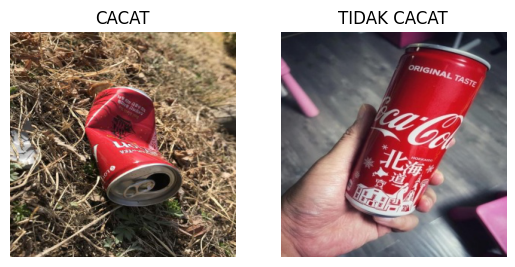

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Load gambar pertama
img1 = mpimg.imread('/content/drive/MyDrive/SKILVUL/Capstone/dataset2_klasifikasi_kaleng/dataseti_kaleng/training/kaleng_cacat/1 (1).jpg')

# Load gambar kedua
img2 = mpimg.imread('/content/drive/MyDrive/SKILVUL/Capstone/dataset2_klasifikasi_kaleng/dataseti_kaleng/training/kaleng_tidak_cacat/-100_jpg.rf.849e45cf02740f23caf0c1198dad6d8b.jpg')

# Plot gambar pertama
plt.subplot(1, 2, 1)
plt.imshow(img1)
plt.axis('off')  # Menghilangkan sumbu

# Plot gambar kedua
plt.subplot(1, 2, 2)
plt.imshow(img2)
plt.axis('off')  # Menghilangkan sumbu

# Tambahkan label
plt.subplot(1, 2, 1)
plt.title('CACAT')

plt.subplot(1, 2, 2)
plt.title('TIDAK CACAT')

plt.show()

##Trying Autokeras

In [ ]:
!pip install --upgrade tensorflow tensorflow-text keras keras-tuner autokeras

In [ ]:
import autokeras as ak
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory

# Direktori data
train_dir = '/content/drive/MyDrive/SKILVUL/Capstone/dataset2_klasifikasi_kaleng/dataseti_kaleng/training'
validation_dir = '/content/drive/MyDrive/SKILVUL/Capstone/dataset2_klasifikasi_kaleng/dataseti_kaleng/validasi'

# Membuat dataset dari direktori
train_dataset = image_dataset_from_directory(
    train_dir,
    image_size=(300, 300),
    batch_size=32,
    label_mode='binary'
)

validation_dataset = image_dataset_from_directory(
    validation_dir,
    image_size=(300, 300),
    batch_size=32,
    label_mode='binary'
)

# Model AutoKeras
clf = ak.ImageClassifier(
    overwrite=True,
    max_trials=10
)

# Latih model
clf.fit(train_dataset, epochs=10, validation_data=validation_dataset)

# Evaluasi model
results = clf.evaluate(validation_dataset)
print(f'Validation accuracy: {results[1] * 100:.2f}%')

Trial 2 Complete [00h 12m 29s]
val_loss: 0.6931058168411255

Best val_loss So Far: 0.6925495862960815
Total elapsed time: 00h 17m 58s

Search: Running Trial #3

Value             |Best Value So Far |Hyperparameter
efficient         |vanilla           |image_block_1/block_type
True              |True              |image_block_1/normalize
True              |False             |image_block_1/augment
True              |None              |image_block_1/image_augmentation_1/horizontal_flip
False             |None              |image_block_1/image_augmentation_1/vertical_flip
0                 |None              |image_block_1/image_augmentation_1/contrast_factor
0                 |None              |image_block_1/image_augmentation_1/rotation_factor
0.1               |None              |image_block_1/image_augmentation_1/translation_factor
0                 |None              |image_block_1/image_augmentation_1/zoom_factor
True              |None              |image_block_1/efficient_net_bloc

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


171/171 ━━━━━━━━━━━━━━━━━━━━ 210s 1s/step - accuracy: 0.5219 - loss: 0.6958 - val_accuracy: 0.5143 - val_loss: 0.6980
Epoch 2/10
171/171 ━━━━━━━━━━━━━━━━━━━━ 189s 1s/step - accuracy: 0.5148 - loss: 0.6988 - val_accuracy: 0.4914 - val_loss: 0.7036
Epoch 3/10
171/171 ━━━━━━━━━━━━━━━━━━━━ 193s 1s/step - accuracy: 0.4997 - loss: 0.7047 - val_accuracy: 0.4886 - val_loss: 0.6979
Epoch 4/10
171/171 ━━━━━━━━━━━━━━━━━━━━ 186s 1s/step - accuracy: 0.5269 - loss: 0.6928 - val_accuracy: 0.4800 - val_loss: 0.7081
Epoch 5/10
171/171 ━━━━━━━━━━━━━━━━━━━━ 200s 1s/step - accuracy: 0.5108 - loss: 0.6988 - val_accuracy: 0.5286 - val_loss: 0.6931
Epoch 6/10
171/171 ━━━━━━━━━━━━━━━━━━━━ 186s 1s/step - accuracy: 0.5274 - loss: 0.6953 - val_accuracy: 0.5543 - val_loss: 0.6982
Epoch 7/10
171/171 ━━━━━━━━━━━━━━━━━━━━ 216s 1s/step - accuracy: 0.4904 - loss: 0.7066 - val_accuracy: 0.5314 - val_loss: 0.6916
Epoch 8/10
171/171 ━━━━━━━━━━━━━━━━━━━━ 186s 1s/step - accuracy: 0.5619 - loss: 0.6934 - val_accuracy: 0.497

## Periksa Isi Direktori

In [ ]:
import os

train_dir = '/content/drive/My Drive/SKILVUL/Capstone/Dataset/training'
validation_dir = '/content/drive/My Drive/SKILVUL/Capstone/Dataset/validasi'

print("Contents of training directory:", os.listdir(train_dir))
print("Contents of validation directory:", os.listdir(validation_dir))

Contents of training directory: ['kaleng_tidak_cacat', 'kaleng_cacat']
Contents of validation directory: ['kaleng_tidak_cacat', 'kaleng_cacat']


## Preprocessing Data

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Data augmentation and preprocessing
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

validation_datagen = ImageDataGenerator(rescale=1./255)

train_dir = '/content/drive/MyDrive/SKILVUL/Capstone/dataset2_klasifikasi_kaleng/dataseti_kaleng/training'
validation_dir = '/content/drive/MyDrive/SKILVUL/Capstone/dataset2_klasifikasi_kaleng/dataseti_kaleng/validasi'

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(300, 300),
    batch_size=32,
    class_mode='binary'
)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(300, 300),
    batch_size=32,
    class_mode='binary'
)

Found 1366 images belonging to 2 classes.
Found 350 images belonging to 2 classes.


## Membangun Model

## Try 1

## resnet

Found 1546 images belonging to 2 classes.
Found 460 images belonging to 2 classes.
Epoch 1/50
48/48 [==============================] - ETA: 0s - loss: 0.7770 - accuracy: 0.4934 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


48/48 [==============================] - 896s 19s/step - loss: 0.7770 - accuracy: 0.4934 - val_loss: 0.7095 - val_accuracy: 0.5045 - lr: 1.0000e-04
Epoch 2/50
48/48 [==============================] - 46s 958ms/step - loss: 0.7579 - accuracy: 0.4822 - val_loss: 0.7018 - val_accuracy: 0.4665 - lr: 1.0000e-04
Epoch 3/50
48/48 [==============================] - 45s 938ms/step - loss: 0.7222 - accuracy: 0.5026 - val_loss: 0.7057 - val_accuracy: 0.5000 - lr: 1.0000e-04
Epoch 4/50
48/48 [==============================] - 45s 949ms/step - loss: 0.7149 - accuracy: 0.4921 - val_loss: 0.7044 - val_accuracy: 0.4821 - lr: 1.0000e-04
Epoch 5/50
48/48 [==============================] - 50s 1s/step - loss: 0.7115 - accuracy: 0.5198 - val_loss: 0.7022 - val_accuracy: 0.4866 - lr: 1.0000e-04
Epoch 6/50
48/48 [==============================] - 48s 993ms/step - loss: 0.7005 - accuracy: 0.5211 - val_loss: 0.7067 - val_accuracy: 0.4978 - lr: 1.0000e-04
Epoch 7/50
48/48 [==============================] - 46s

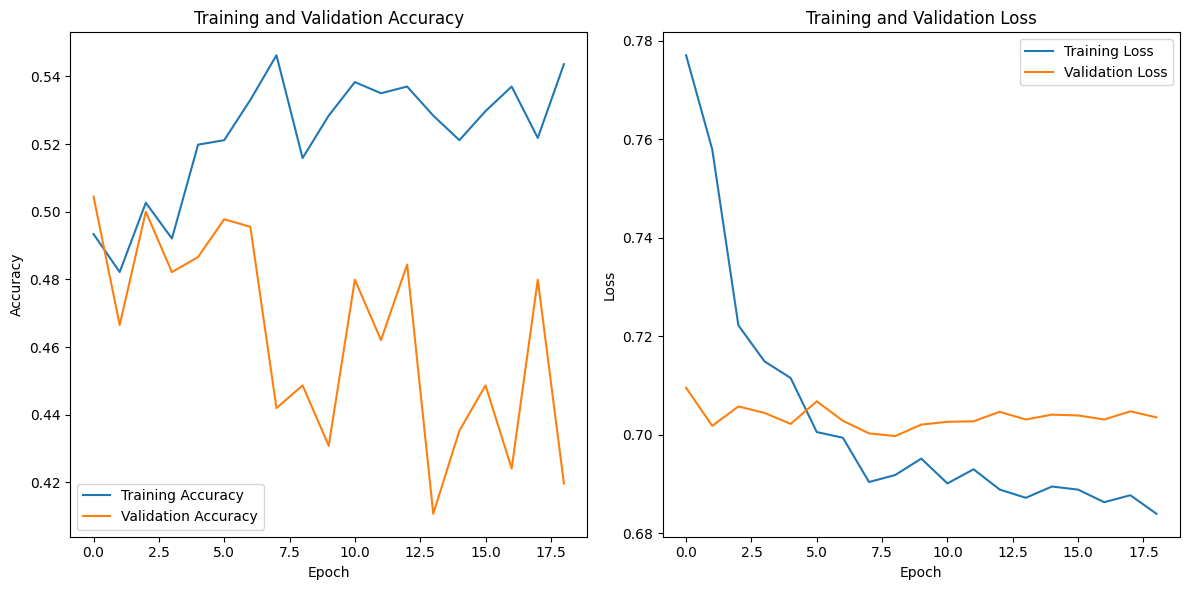

In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

# Load the ResNet50 model pre-trained on ImageNet, excluding the top layer
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(300, 300, 3))

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Build the model
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(loss='binary_crossentropy',
              optimizer=Adam(learning_rate=0.0001),
              metrics=['accuracy'])

# Callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True, mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

validation_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    '/content/drive/MyDrive/SKILVUL/Capstone/dataset_klasifikasi_kaleng-20240527T094041Z-001/dataset_klasifikasi_kaleng/training',
    target_size=(300, 300),
    batch_size=32,
    class_mode='binary'
)

validation_generator = validation_datagen.flow_from_directory(
    '/content/drive/MyDrive/SKILVUL/Capstone/dataset_klasifikasi_kaleng-20240527T094041Z-001/dataset_klasifikasi_kaleng/validation',
    target_size=(300, 300),
    batch_size=32,
    class_mode='binary'
)

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=50,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    callbacks=[reduce_lr, checkpoint, early_stopping]
)

# Plotting the training and validation curves
plt.figure(figsize=(12, 6))

# Plotting accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

# Plotting loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Building the CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(300, 300, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Print model summary to check the dimensions
model.summary()

# Compile the model
model.compile(loss='binary_crossentropy',
              optimizer=Adam(learning_rate=0.001),
              metrics=['accuracy'])

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=50,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
)

# Plotting the training and validation curves
plt.figure(figsize=(12, 6))

# Plotting accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

# Plotting loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 298, 298, 32)      896       
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 149, 149, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 147, 147, 64)      18496     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 73, 73, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 71, 71, 128)       73856     
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 35, 35, 128)      

## Try 2

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam


# Building the CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(300, 300, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])


# Compile the model
model.compile(loss='binary_crossentropy',
              optimizer=Adam(learning_rate=0.001),
              metrics=['accuracy'])

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=50,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
)

# Plotting the training and validation curves
plt.figure(figsize=(12, 6))

# Plotting accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

# Plotting loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()

Epoch 1/50


InvalidArgumentError: Graph execution error:

Detected at node sequential_4/dense_8/MatMul defined at (most recent call last):
  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code

  File "/usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py", line 37, in <module>

  File "/usr/local/lib/python3.10/dist-packages/traitlets/config/application.py", line 992, in launch_instance

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelapp.py", line 619, in start

  File "/usr/local/lib/python3.10/dist-packages/tornado/platform/asyncio.py", line 195, in start

  File "/usr/lib/python3.10/asyncio/base_events.py", line 603, in run_forever

  File "/usr/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once

  File "/usr/lib/python3.10/asyncio/events.py", line 80, in _run

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 685, in <lambda>

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 738, in _run_callback

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 825, in inner

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 786, in run

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 361, in process_one

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 261, in dispatch_shell

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 539, in execute_request

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py", line 302, in do_execute

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/zmqshell.py", line 539, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 2975, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3030, in _run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3257, in run_cell_async

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3473, in run_ast_nodes

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code

  File "<ipython-input-10-759f5ff3ad85>", line 29, in <cell line: 29>

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1807, in fit

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1401, in train_function

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1384, in step_function

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1373, in run_step

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1150, in train_step

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 590, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/sequential.py", line 398, in call

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py", line 515, in call

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py", line 672, in _run_internal_graph

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py", line 241, in call

Matrix size-incompatible: In[0]: [32,32768], In[1]: [6272,512]
	 [[{{node sequential_4/dense_8/MatMul}}]] [Op:__inference_train_function_6866]

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt

# Building the CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(300, 300, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(512, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(loss='binary_crossentropy',
              optimizer=Adam(learning_rate=0.001),
              metrics=['accuracy'])

# Data augmentation
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1. / 255)

# Train and validation generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(300, 300),
    batch_size=batch_size,
    class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
    validation_dir,
    target_size=(300, 300),
    batch_size=batch_size,
    class_mode='binary')

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=50,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    callbacks=[early_stopping, reduce_lr]
)

# Plotting the training and validation curves
plt.figure(figsize=(12, 6))

# Plotting accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

# Plotting loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()

NameError: name 'batch_size' is not defined

## Try 1 with early stopping


Found 1366 images belonging to 2 classes.
Found 350 images belonging to 2 classes.
Epoch 1/50
42/42 [==============================] - 787s 19s/step - loss: 1.2034 - accuracy: 0.5247 - val_loss: 0.9578 - val_accuracy: 0.5094 - lr: 0.0010
Epoch 2/50
42/42 [==============================] - 38s 902ms/step - loss: 0.8487 - accuracy: 0.5457 - val_loss: 0.8862 - val_accuracy: 0.4594 - lr: 0.0010
Epoch 3/50
42/42 [==============================] - 40s 961ms/step - loss: 0.7825 - accuracy: 0.5417 - val_loss: 0.8122 - val_accuracy: 0.4219 - lr: 0.0010
Epoch 4/50
42/42 [==============================] - 40s 951ms/step - loss: 0.7391 - accuracy: 0.5555 - val_loss: 0.7525 - val_accuracy: 0.4125 - lr: 0.0010
Epoch 5/50
42/42 [==============================] - 40s 948ms/step - loss: 0.7261 - accuracy: 0.5640 - val_loss: 0.7798 - val_accuracy: 0.4219 - lr: 0.0010
Epoch 6/50
42/42 [==============================] - 39s 923ms/step - loss: 0.7037 - accuracy: 0.6124 - val_loss: 0.7395 - val_accuracy: 0.

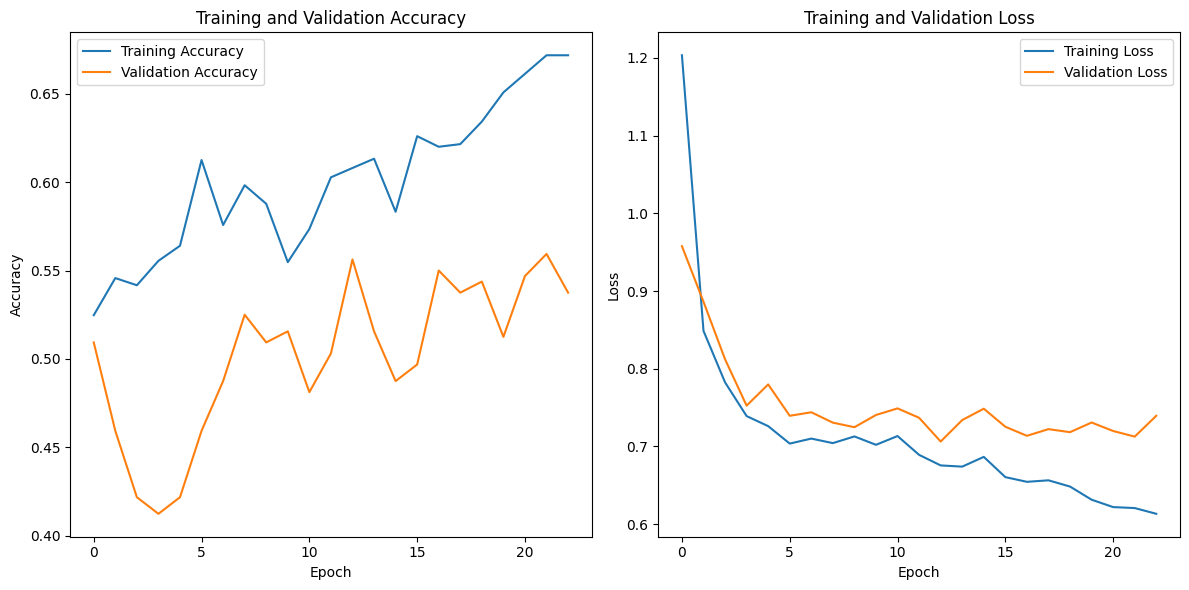

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt

# Definisikan batch size
batch_size = 32

# Building the CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(300, 300, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(512, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(loss='binary_crossentropy',
              optimizer=Adam(learning_rate=0.001),
              metrics=['accuracy'])

# Data augmentation and preprocessing
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

validation_datagen = ImageDataGenerator(rescale=1./255)

train_dir = '/content/drive/MyDrive/SKILVUL/Capstone/dataset2_klasifikasi_kaleng/dataseti_kaleng/training'
validation_dir = '/content/drive/MyDrive/SKILVUL/Capstone/dataset2_klasifikasi_kaleng/dataseti_kaleng/validasi'

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(300, 300),
    batch_size=batch_size,
    class_mode='binary'
)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(300, 300),
    batch_size=batch_size,
    class_mode='binary'
)

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=50,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    callbacks=[early_stopping, reduce_lr]
)

# Plotting the training and validation curves
plt.figure(figsize=(12, 6))

# Plotting accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

# Plotting loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()

## Try 2 without early stopping

Found 750 images belonging to 2 classes.
Found 150 images belonging to 2 classes.
Epoch 1/50
23/23 [==============================] - ETA: 0s - loss: 0.7588 - accuracy: 0.4769

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


23/23 [==============================] - 142s 6s/step - loss: 0.7588 - accuracy: 0.4769 - val_loss: 0.6926 - val_accuracy: 0.5625 - lr: 0.0010
Epoch 2/50
23/23 [==============================] - 21s 933ms/step - loss: 0.6935 - accuracy: 0.4861 - val_loss: 0.6909 - val_accuracy: 0.5234 - lr: 0.0010
Epoch 3/50
23/23 [==============================] - 22s 963ms/step - loss: 0.6924 - accuracy: 0.5014 - val_loss: 0.6799 - val_accuracy: 0.5469 - lr: 0.0010
Epoch 4/50
23/23 [==============================] - 20s 860ms/step - loss: 0.6891 - accuracy: 0.5028 - val_loss: 0.6615 - val_accuracy: 0.5078 - lr: 0.0010
Epoch 5/50
23/23 [==============================] - 22s 963ms/step - loss: 0.6990 - accuracy: 0.5097 - val_loss: 0.6696 - val_accuracy: 0.5781 - lr: 0.0010
Epoch 6/50
23/23 [==============================] - 22s 979ms/step - loss: 0.6917 - accuracy: 0.5028 - val_loss: 0.6807 - val_accuracy: 0.6094 - lr: 0.0010
Epoch 7/50
23/23 [==============================] - 21s 921ms/step - loss: 0.

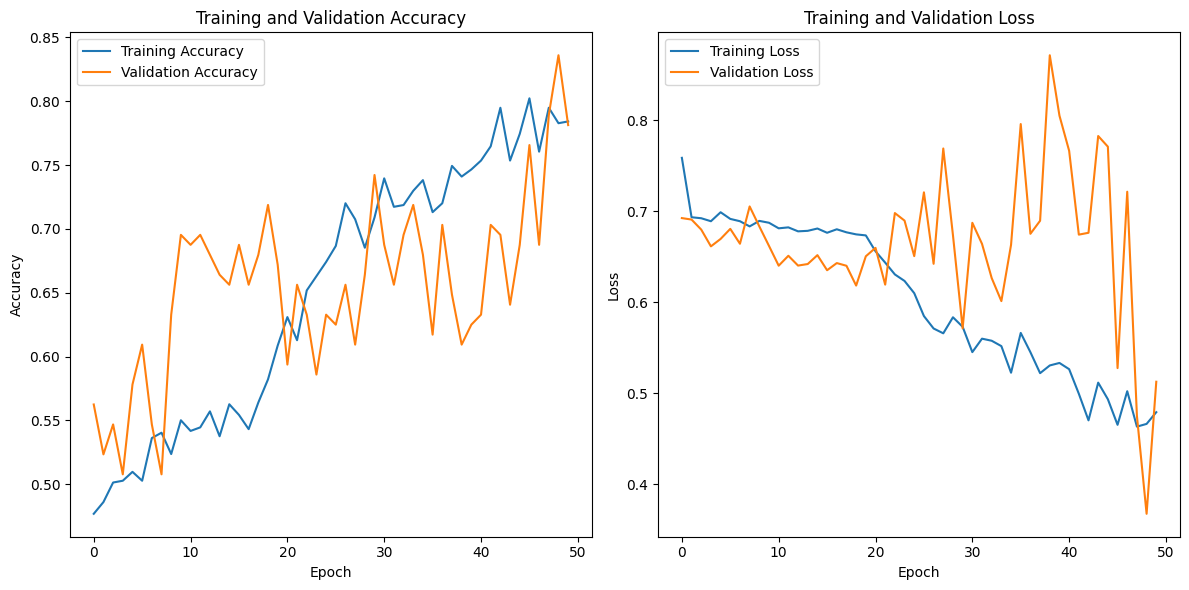

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
import matplotlib.pyplot as plt
import os

# Definisikan batch size
batch_size = 32

# Building the CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(300, 300, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(loss='binary_crossentropy',
              optimizer=Adam(learning_rate=0.001),
              metrics=['accuracy'])

# Data augmentation and preprocessing
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

validation_datagen = ImageDataGenerator(rescale=1./255)

train_dir = '/content/drive/My Drive/SKILVUL/Capstone/Dataset/training'
validation_dir = '/content/drive/My Drive/SKILVUL/Capstone/Dataset/validasi'

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(300, 300),  # Sesuaikan dengan input shape model
    batch_size=batch_size,
    class_mode='binary'
)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(300, 300),  # Sesuaikan dengan input shape model
    batch_size=batch_size,
    class_mode='binary'
)

# Callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)
checkpoint = ModelCheckpoint('model1.h5', monitor='val_accuracy', save_best_only=True, mode='max')

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=50,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    callbacks=[reduce_lr, checkpoint]  # Menambahkan ModelCheckpoint
)

# Plotting the training and validation curves
plt.figure(figsize=(12, 6))

# Plotting accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

# Plotting loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()

## Try 3

* Meningkatkan dropout rate menjadi 0.7.
* Mengubah learning rate menjadi 0.0001.
* Menambahkan variasi augmentasi dengan rentang yang lebih luas.
* Menggunakan callback ModelCheckpoint untuk menyimpan model terbaik.

Found 1546 images belonging to 2 classes.
Found 460 images belonging to 2 classes.
Epoch 1/50
48/48 [==============================] - ETA: 0s - loss: 0.6955 - accuracy: 0.5192
Epoch 1: val_accuracy improved from -inf to 0.52009, saving model to best_model.h5
48/48 [==============================] - 48s 948ms/step - loss: 0.6955 - accuracy: 0.5192 - val_loss: 0.6916 - val_accuracy: 0.5201 - lr: 1.0000e-04
Epoch 2/50
48/48 [==============================] - ETA: 0s - loss: 0.6799 - accuracy: 0.5357
Epoch 2: val_accuracy improved from 0.52009 to 0.54911, saving model to best_model.h5
48/48 [==============================] - 44s 922ms/step - loss: 0.6799 - accuracy: 0.5357 - val_loss: 0.7120 - val_accuracy: 0.5491 - lr: 1.0000e-04
Epoch 3/50
48/48 [==============================] - ETA: 0s - loss: 0.6621 - accuracy: 0.5852
Epoch 3: val_accuracy did not improve from 0.54911
48/48 [==============================] - 43s 904ms/step - loss: 0.6621 - accuracy: 0.5852 - val_loss: 0.7316 - val_ac

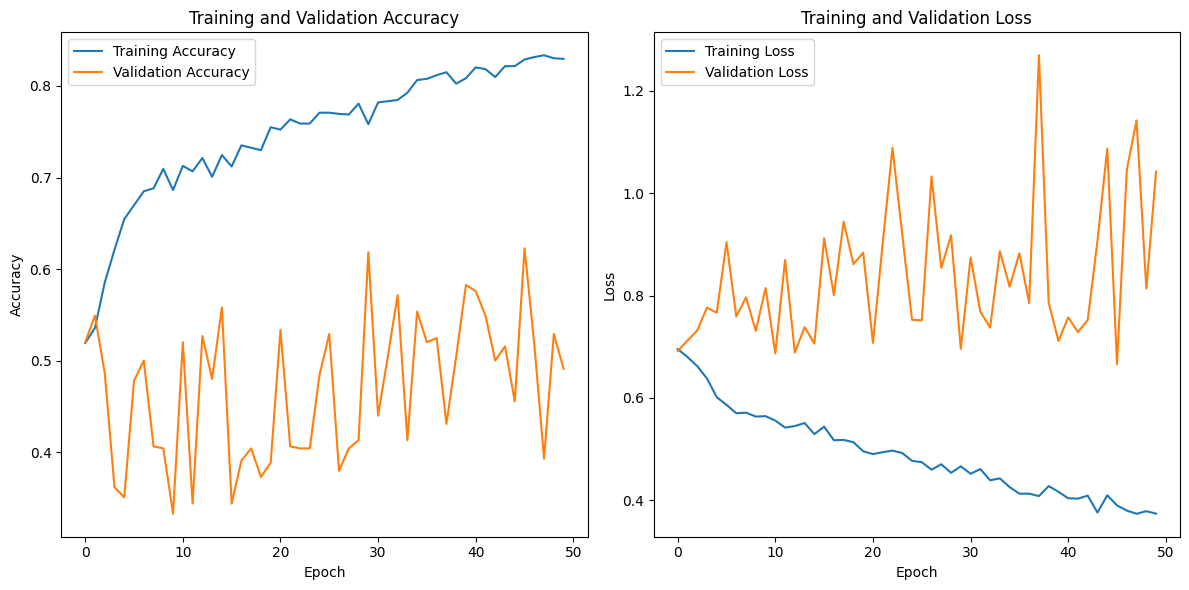

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
import matplotlib.pyplot as plt
import os

# Definisikan batch size
batch_size = 32

# Building the CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(300, 300, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.7),  # Meningkatkan dropout rate
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(loss='binary_crossentropy',
              optimizer=Adam(learning_rate=0.0001),  # Mengubah learning rate
              metrics=['accuracy'])

# Data augmentation and preprocessing
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=45,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    fill_mode='nearest'
)

validation_datagen = ImageDataGenerator(rescale=1./255)

train_dir = '/content/drive/MyDrive/SKILVUL/Capstone/dataset_klasifikasi_kaleng-20240527T094041Z-001/dataset_klasifikasi_kaleng/training'
validation_dir = '/content/drive/MyDrive/SKILVUL/Capstone/dataset_klasifikasi_kaleng-20240527T094041Z-001/dataset_klasifikasi_kaleng/validation'

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(300, 300),
    batch_size=batch_size,
    class_mode='binary'
)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(300, 300),
    batch_size=batch_size,
    class_mode='binary'
)

# Callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)
checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=50,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    callbacks=[reduce_lr, checkpoint]  # Menggunakan callbacks reduce_lr dan ModelCheckpoint
)

# Plotting the training and validation curves
plt.figure(figsize=(12, 6))

# Plotting accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

# Plotting loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()

## MobileNet

In [ ]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
import matplotlib.pyplot as plt
import os

# Definisikan batch size
batch_size = 32

# Load MobileNetV2 model pre-trained on ImageNet and add custom layers on top
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(300, 300, 3))
base_model.trainable = False  # Freeze the base model

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(512, activation='relu'),
    Dropout(0.7),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(loss='binary_crossentropy',
              optimizer=Adam(learning_rate=0.0001),
              metrics=['accuracy'])

# Data augmentation and preprocessing
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=45,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    fill_mode='nearest'
)

validation_datagen = ImageDataGenerator(rescale=1./255)

train_dir = '/content/drive/MyDrive/SKILVUL/Capstone/dataset_klasifikasi_kaleng-20240527T094041Z-001/dataset_klasifikasi_kaleng/training'
validation_dir = '/content/drive/MyDrive/SKILVUL/Capstone/dataset_klasifikasi_kaleng-20240527T094041Z-001/dataset_klasifikasi_kaleng/validation'

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(300, 300),
    batch_size=batch_size,
    class_mode='binary'
)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(300, 300),
    batch_size=batch_size,
    class_mode='binary'
)

# Callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=50,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    callbacks=[reduce_lr, checkpoint]
)

# Plotting the training and validation curves
plt.figure(figsize=(12, 6))

# Plotting accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

# Plotting loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()

Found 1546 images belonging to 2 classes.
Found 460 images belonging to 2 classes.
Epoch 1/50
48/48 [==============================] - ETA: 0s - loss: 0.6141 - accuracy: 0.6513
Epoch 1: val_accuracy did not improve from 0.50670
48/48 [==============================] - 90s 2s/step - loss: 0.6141 - accuracy: 0.6513 - val_loss: 0.7984 - val_accuracy: 0.4487 - lr: 1.0000e-04
Epoch 2/50
48/48 [==============================] - ETA: 0s - loss: 0.3853 - accuracy: 0.8421
Epoch 2: val_accuracy did not improve from 0.50670
48/48 [==============================] - 45s 942ms/step - loss: 0.3853 - accuracy: 0.8421 - val_loss: 0.8641 - val_accuracy: 0.4621 - lr: 1.0000e-04
Epoch 3/50
48/48 [==============================] - ETA: 0s - loss: 0.3291 - accuracy: 0.8639
Epoch 3: val_accuracy did not improve from 0.50670
48/48 [==============================] - 45s 919ms/step - loss: 0.3291 - accuracy: 0.8639 - val_loss: 0.9297 - val_accuracy: 0.4888 - lr: 1.0000e-04
Epoch 4/50
48/48 [====================

KeyboardInterrupt: 

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Building the CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(300, 300, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_16 (MaxPooli  (None, 74, 74, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_17 (Conv2D)          (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_17 (MaxPooli  (None, 36, 36, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_18 (Conv2D)          (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_18 (MaxPooli  (None, 17, 17, 128)      

## Mengompilasi Model

In [ ]:
from tensorflow.keras.optimizers import Adam

# Compile the model
model.compile(loss='binary_crossentropy',
              optimizer=Adam(learning_rate=0.001),
              metrics=['accuracy'])

## Melatih Model

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=50,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    callbacks=[early_stopping]
)

Epoch 1/50
23/23 [==============================] - 176s 8s/step - loss: 0.7202 - accuracy: 0.4861 - val_loss: 0.6952 - val_accuracy: 0.4766
Epoch 2/50
23/23 [==============================] - 48s 2s/step - loss: 0.6936 - accuracy: 0.5223 - val_loss: 0.6921 - val_accuracy: 0.8203
Epoch 3/50
23/23 [==============================] - 49s 2s/step - loss: 0.6941 - accuracy: 0.5237 - val_loss: 0.6924 - val_accuracy: 0.5000
Epoch 4/50
23/23 [==============================] - 48s 2s/step - loss: 0.6930 - accuracy: 0.5014 - val_loss: 0.6789 - val_accuracy: 0.6172
Epoch 5/50
23/23 [==============================] - 48s 2s/step - loss: 0.6887 - accuracy: 0.5474 - val_loss: 0.7037 - val_accuracy: 0.4844
Epoch 6/50
23/23 [==============================] - 48s 2s/step - loss: 0.6915 - accuracy: 0.5251 - val_loss: 0.6918 - val_accuracy: 0.5234
Epoch 7/50
23/23 [==============================] - 48s 2s/step - loss: 0.6937 - accuracy: 0.4944 - val_loss: 0.6860 - val_accuracy: 0.7656
Epoch 8/50
23/23 [=

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping

# Define the CNN model with adjusted input shape and layers
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(300, 300, 3)),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    GlobalAveragePooling2D(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.summary()

# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=50,
    validation_data=test_generator,
    validation_steps=test_generator.samples // test_generator.batch_size,
    callbacks=[early_stopping]
)


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 298, 298, 32)      896       
                                                                 
 batch_normalization (Batch  (None, 298, 298, 32)      128       
 Normalization)                                                  
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 149, 149, 32)      0         
 ng2D)                                                           
                                                                 
 conv2d_13 (Conv2D)          (None, 147, 147, 64)      18496     
                                                                 
 batch_normalization_1 (Bat  (None, 147, 147, 64)      256       
 chNormalization)                                                
                                                      

NameError: name 'train_generator' is not defined

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

# Membangun model CNN dengan beberapa perubahan
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(300, 300, 3)),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    GlobalAveragePooling2D(),  # Mengganti Flatten dengan GlobalAveragePooling2D
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Menggunakan optimizer Adam dengan laju pembelajaran yang disesuaikan
optimizer = Adam(learning_rate=0.001)

# Mengompilasi model dengan menggunakan binary crossentropy sebagai fungsi loss
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Menambahkan early stopping untuk menghentikan pelatihan jika tidak terjadi perbaikan pada validasi
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Pelatihan model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=50,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    callbacks=[early_stopping]
)
# Plot hasil pelatihan
plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Epoch 1/50
23/23 [==============================] - 13s 414ms/step - loss: 0.6829 - accuracy: 0.5891 - val_loss: 0.6806 - val_accuracy: 0.5469
Epoch 2/50
23/23 [==============================] - 9s 414ms/step - loss: 0.5792 - accuracy: 0.7187 - val_loss: 0.6780 - val_accuracy: 0.5312
Epoch 3/50
23/23 [==============================] - 8s 345ms/step - loss: 0.5784 - accuracy: 0.7159 - val_loss: 0.7346 - val_accuracy: 0.5156
Epoch 4/50
23/23 [==============================] - 10s 436ms/step - loss: 0.5105 - accuracy: 0.7549 - val_loss: 0.7200 - val_accuracy: 0.6094
Epoch 5/50
23/23 [==============================] - 10s 420ms/step - loss: 0.4924 - accuracy: 0.7688 - val_loss: 0.9541 - val_accuracy: 0.4922
Epoch 6/50
23/23 [==============================] - 8s 367ms/step - loss: 0.4395 - accuracy: 0.8008 - val_loss: 1.1949 - val_accuracy: 0.4922
Epoch 7/50
23/23 [==============================] - 9s 413ms/step - loss: 0.4399 - accuracy: 0.7897 - val_loss: 1.4506 - val_accuracy: 0.5234
Epo

## Evaluasi Model

In [ ]:
# Evaluate the model
loss, accuracy = model.evaluate(validation_generator)
print(f'Validation loss: {loss}')
print(f'Validation accuracy: {accuracy}')

5/5 [==============================] - 1s 231ms/step - loss: 0.6922 - accuracy: 0.5467
Validation loss: 0.6921610832214355
Validation accuracy: 0.54666668176651


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt
import keras

Found 750 images belonging to 2 classes.
Found 150 images belonging to 2 classes.
58889256/58889256 [==============================] - 5s 0us/step
Epoch 1/14
24/24 [==============================] - 412s 17s/step - loss: 0.4128 - accuracy: 0.7947 - val_loss: 0.4201 - val_accuracy: 0.8200
Epoch 2/14
24/24 [==============================] - 23s 945ms/step - loss: 0.2055 - accuracy: 0.9107 - val_loss: 0.2140 - val_accuracy: 0.9200
Epoch 3/14
24/24 [==============================] - 23s 931ms/step - loss: 0.1457 - accuracy: 0.9387 - val_loss: 0.3418 - val_accuracy: 0.8800
Epoch 4/14
24/24 [==============================] - 22s 896ms/step - loss: 0.1152 - accuracy: 0.9587 - val_loss: 0.2444 - val_accuracy: 0.9133
Epoch 5/14
24/24 [==============================] - 22s 907ms/step - loss: 0.0955 - accuracy: 0.9653 - val_loss: 0.2043 - val_accuracy: 0.9267
Epoch 6/14
24/24 [==============================] - 23s 953ms/step - loss: 0.0707 - accuracy: 0.9787 - val_loss: 0.1583 - val_accuracy: 0.9

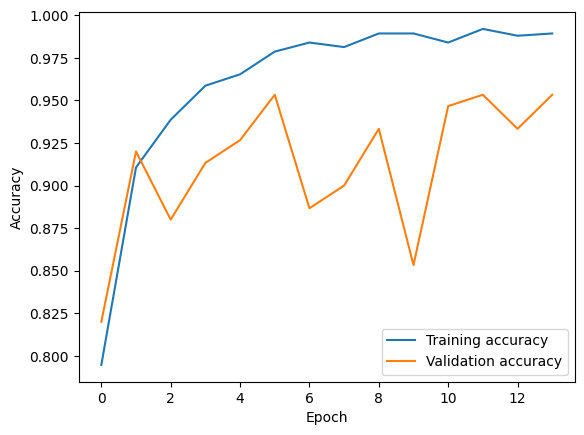

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16  # Import VGG16 model

# Memuat dan mempersiapkan data
train_data_dir = ('/content/drive/My Drive/SKILVUL/Capstone/Dataset/training/')
test_data_dir = ('/content/drive/My Drive/SKILVUL/Capstone/Dataset/validasi/')
input_shape = (300, 300, 3)

# Membuat generator untuk augmentasi data
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

# Menggunakan generator untuk memuat data latih dan data validasi
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(300, 300),
    batch_size=32,
    class_mode='binary')

test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(300, 300),
    batch_size=32,
    class_mode='binary')

# Gunakan model pre-trained VGG16 sebagai base model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(300, 300, 3))

# Freeze base model layers
for layer in base_model.layers:
    layer.trainable = False

# Buat model baru berdasarkan base model VGG16
model = models.Sequential([
    base_model,
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

# Compile model
opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=opt,
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Melatih model dengan dataset
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=14,
    validation_data=test_generator,
    validation_steps=len(test_generator))

# Evaluasi model
loss, accuracy = model.evaluate(test_generator, steps=len(test_generator))
print(f'Test accuracy: {accuracy}')

# Plot hasil pelatihan
plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()